# Time Series Analysis – Gauge Data
**Gauge Units**: **feet**

**Goals**
- Predict minor, moderate, and major flood stages over the next 1+ years
- Use SARIMA model
- Based on [Kaggle Code](https://www.kaggle.com/code/sandhyakrishnan02/time-series-analysis-and-forecasting)

**Procedure**
- Data Cleanup
- Visual Stationarity check
- ADF Test
- SARIMA Modeling

In [149]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt # Visualization
mpl.rcParams['figure.dpi'] = 150

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

np.random.seed(0)
sns.set()

In [4]:
gauge = pd.read_csv("Data/Daily_Max_Vals.csv", index_col=0)
gauge.head()

,date,stid,gauge,discharge,rainfall_inches,rainfall_ft
0,2007-10-01,RA101,2.40,23.9,0.0,0.0
1,2007-10-02,RA101,2.39,23.2,0.0,0.0
2,2007-10-03,RA101,2.39,23.2,0.0,0.0
3,2007-10-04,RA101,2.39,23.2,0.0,0.0
4,2007-10-05,RA101,2.42,25.2,0.0,0.0


In [5]:
gauge = gauge[['date', 'gauge']]
gauge.head()

,date,gauge
0,2007-10-01,2.40
1,2007-10-02,2.39
2,2007-10-03,2.39
3,2007-10-04,2.39
4,2007-10-05,2.42


Since this is a TimeSeries problem, we have to parse 'date' column

In [9]:
gauge['date'] = pd.to_datetime(gauge['date'], infer_datetime_format=True)
gauge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5477 entries, 0 to 5476
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5477 non-null   datetime64[ns]
 1   gauge   5477 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 128.4 KB


In [11]:
# No null values!
gauge.isnull().sum()

date     0
gauge    0
dtype: int64

<AxesSubplot:xlabel='date', ylabel='gauge'>

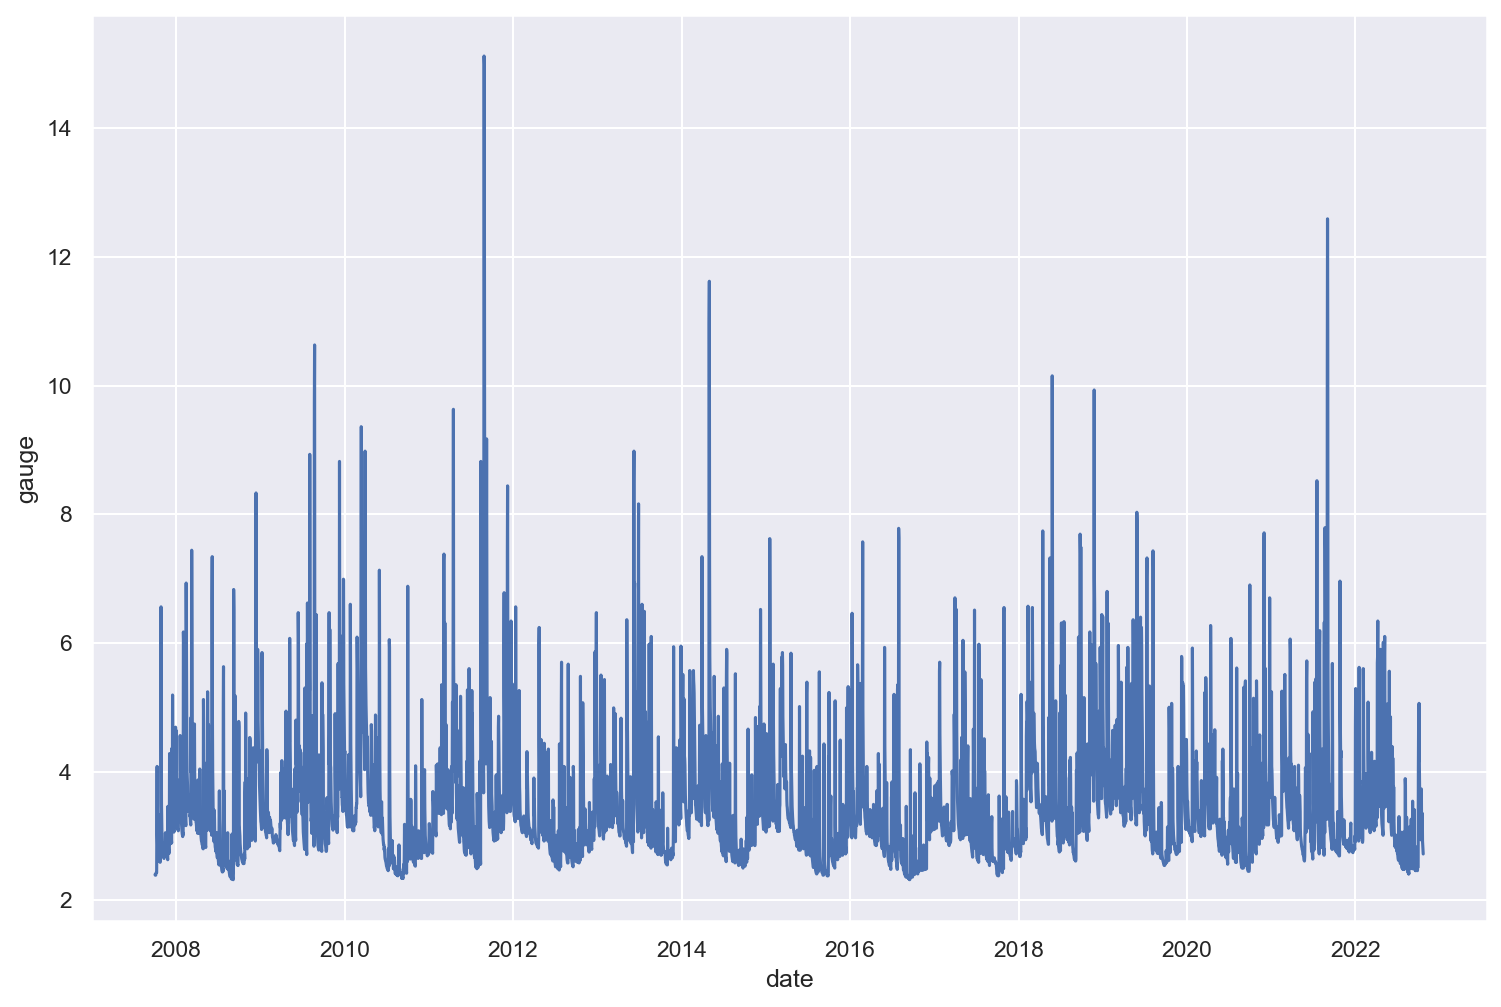

In [16]:
plt.figure(figsize=(12,8), dpi=150)
sns.lineplot(x=gauge['date'], y=gauge['gauge'])

## Stationarity

Some time-series models such as ARIMA assume that the underlying data is stationary. Stationarity describes that the time-series has

* constant mean and mean is not time-dependent
* constant variance and variance is not time-dependent
* constant covariance and covariance is not time-dependent

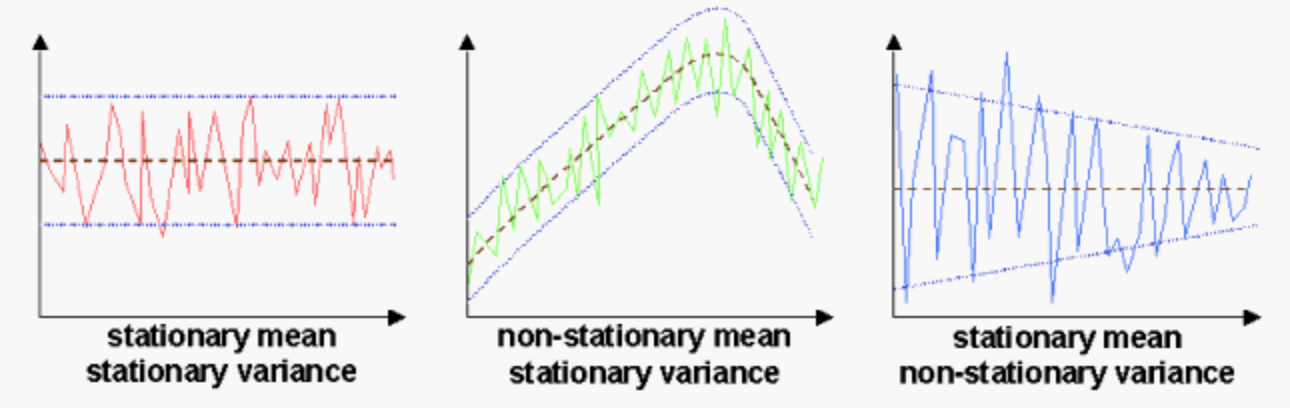

The check for stationarity can be done via three different approaches:

1. **visually**: plot time series and check for trends or seasonality
2. **basic statistics**: split time series and compare the mean and variance of each partition
3. **statistical test**: Augmented Dickey Fuller test

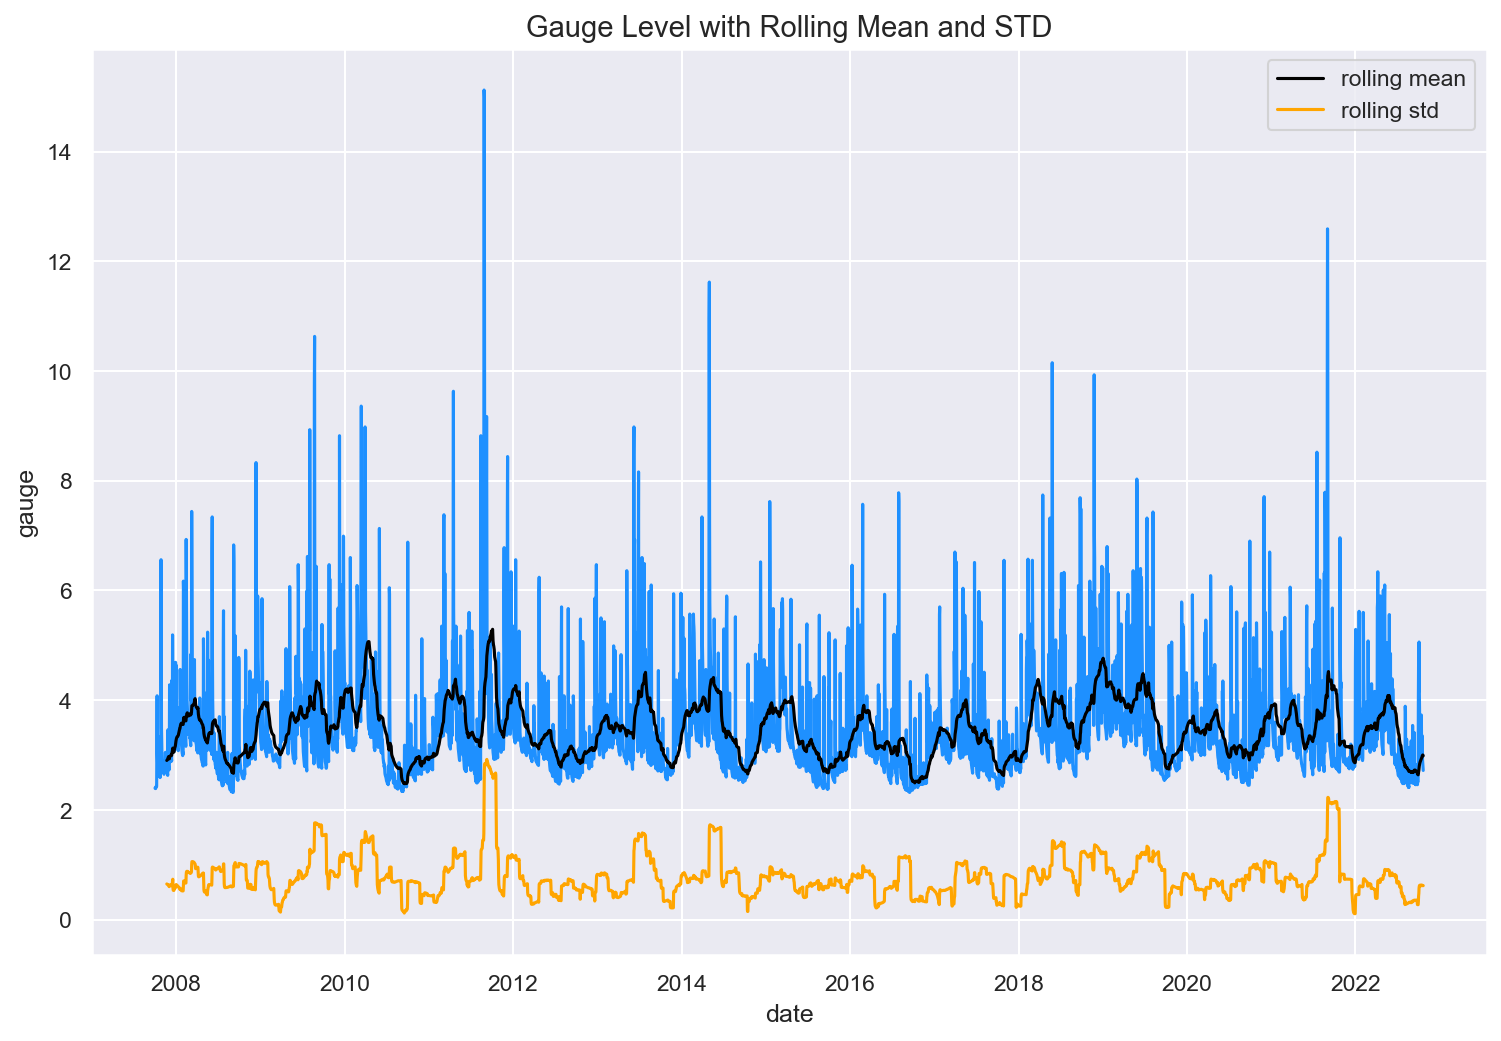

In [40]:
rolling_window = 52
plt.figure(figsize=(12,8), dpi=150)

sns.lineplot(x=gauge['date'], y=gauge['gauge'], color='dodgerblue')
sns.lineplot(x=gauge['date'], y=gauge['gauge'].rolling(rolling_window).mean(), color='black', label='rolling mean')
sns.lineplot(x=gauge['date'], y=gauge['gauge'].rolling(rolling_window).std(), color='orange', label='rolling std')
		 
plt.title('Gauge Level with Rolling Mean and STD', fontsize=14)
plt.show()

In this **visual check**, we can see that the **features don't have constant mean and std**, but they are close to it.

## Augmented Dickey-Fuller (ADF)

**Augmented Dickey-Fuller (ADF)** test is a unit root test. Unit roots (complex roots >= 1) are a cause for non-stationarity.

- Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

- Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

**If the null hypothesis can be rejected, we can conclude that the time series is stationary.**

There are two ways to reject the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

* <font color='red'>**p-value > significance level (default: 0.05)**</font>: Fail to reject the null hypothesis (H0), the data has a unit root and is <font color='red'>non-stationary</font>.
* <font color='green'>**p-value <= significance level (default: 0.05)**</font>: Reject the null hypothesis (H0), the data does not have a unit root and is <font color='green'>stationary</font>.
    
On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.
* <font color='red'>**ADF statistic > critical value**</font>: Fail to reject the null hypothesis (H0), the data has a unit root and is <font color='red'>non-stationary</font>.
* <font color='green'>**ADF statistic < critical value**</font>: Reject the null hypothesis (H0), the data does not have a unit root and is <font color='green'>stationary</font>.

In [42]:
result = adfuller(gauge['gauge'].values)
result

(-11.419242324455748,
 6.938960764602319e-21,
 14,
 5462,
 {'1%': -3.43154779858949,
  '5%': -2.8620693073079546,
  '10%': -2.5670517492274776},
 11542.911032674094)

Now, we are going to check for each variable:
* The p-value is less than 0.05
* Check the range of the ADF statistic compared with critical_values 

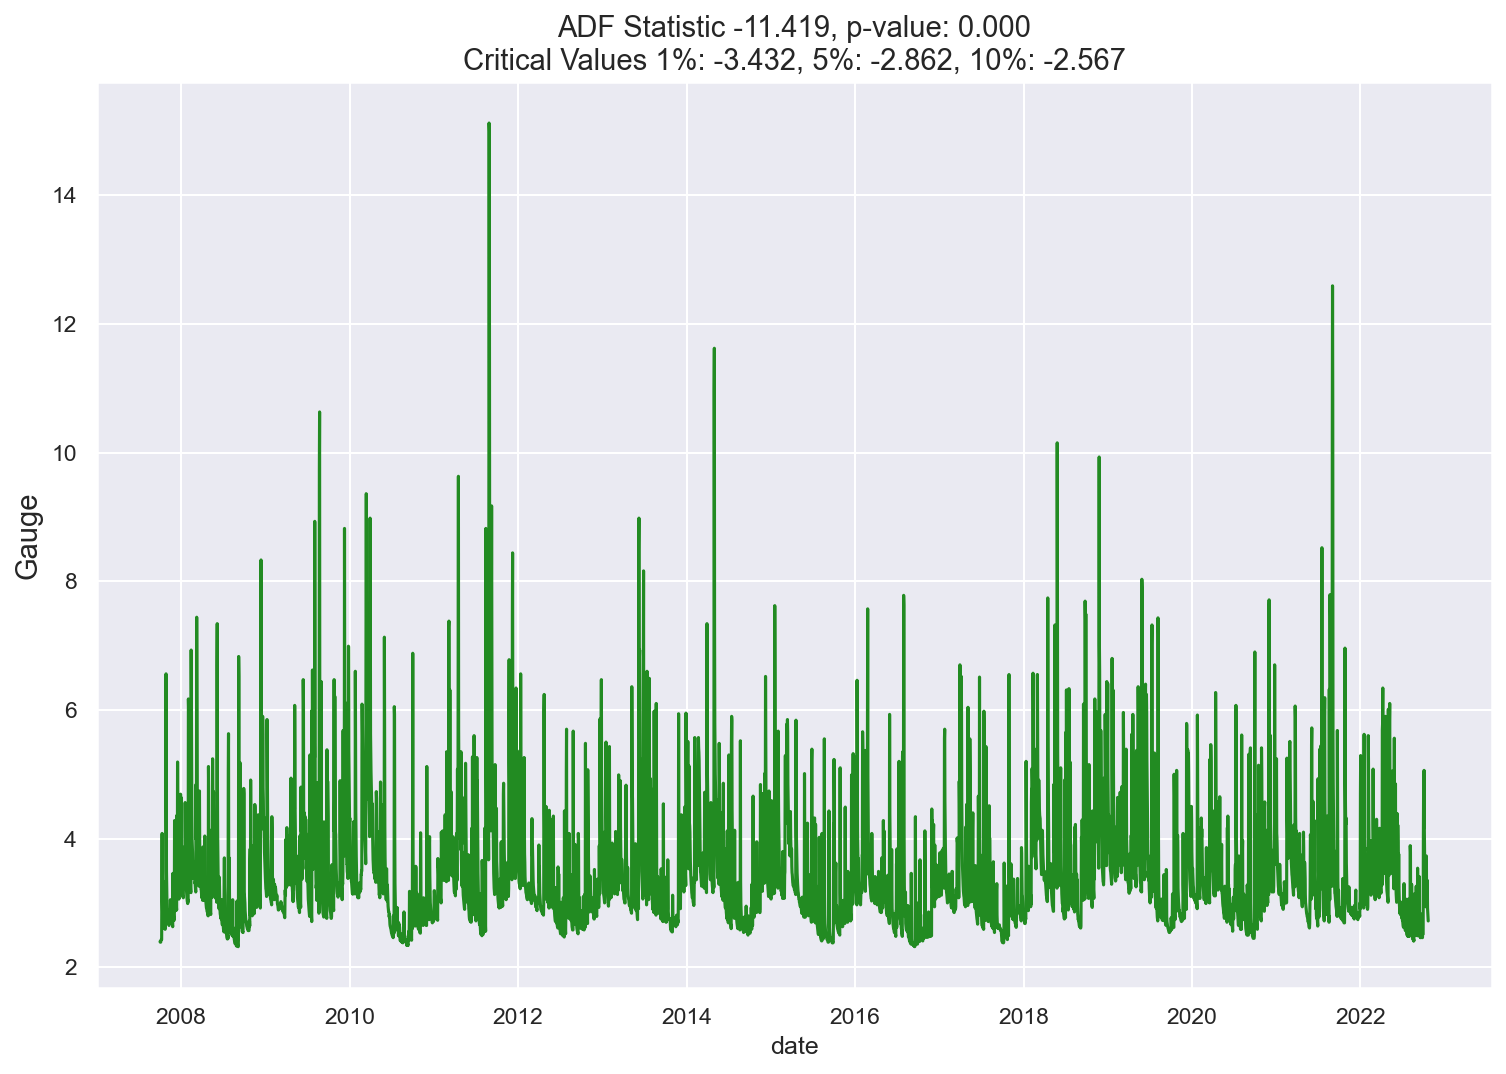

In [50]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
plt.figure(figsize=(12,8), dpi=150)

def visualize_adfuller_results(series, title):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=gauge['date'], y=series, color=linecolor)
    plt.title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    plt.ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(gauge['gauge'], 'Gauge')
plt.show()

If our data were not stationary, it would need to be transformed using log, square root, or differencing.

However, it looks like our stationarity checks went well, so we can skip this transformation step!

## TimeSeries Decomposition

Time series decomposition breaks a series into components: level, trend, seasonality, and noise.

These components are defined as follows:

* **Level**: The average value in the series.
* **Trend**: The increasing or decreasing value in the series.
* **Seasonality**: The repeating short-term cycle in the series.
* **Noise**: The random variation in the series.

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

All series have a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively:
* **Additive**: $y(t) = Level + Trend + Seasonality + Noise$
* **Multiplicative**: $y(t) = Level * Trend * Seasonality * Noise$

In this case we are going to use seasonal_decompose() from the [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) library.

In [90]:
# 1 week, 2 weeks, 1 month, 3 months, 6 months, 1 year, 2, 3, 4, 5 years
periods = [7, 14, 30, 90, 180, 365, 730, 1095, 1460, 1825]

In [91]:
def plot_decomp(per=int):
	decomp = seasonal_decompose(gauge['gauge'], period=per, model='additive', extrapolate_trend='freq')
	gauge[f"gauge_trend"] = decomp.trend
	gauge[f"gauge_seasonal"] = decomp.seasonal
	decomp.plot()
	# Get current figure and adjust size; regular adjustment not working
	plt.gcf().set_size_inches(12, 12)
	print(f'Gauge, Period: {per} Days')
	plt.show()

Gauge, Period: 7 Days


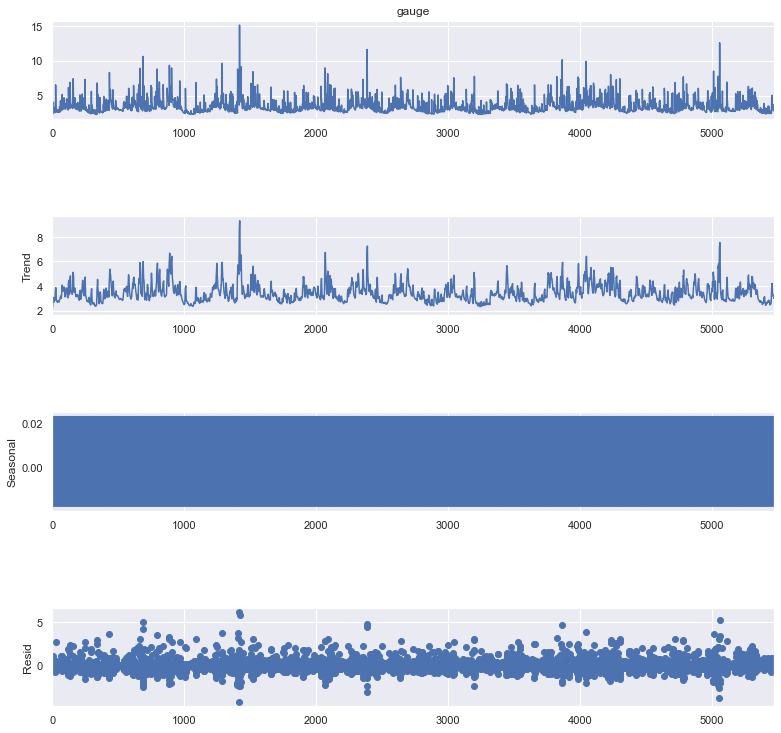

Gauge, Period: 14 Days


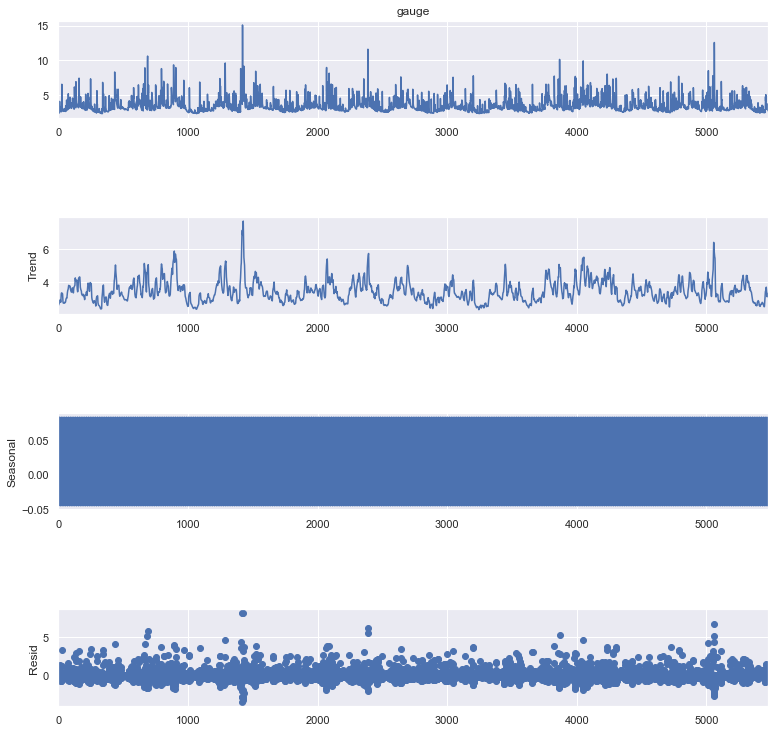

Gauge, Period: 30 Days


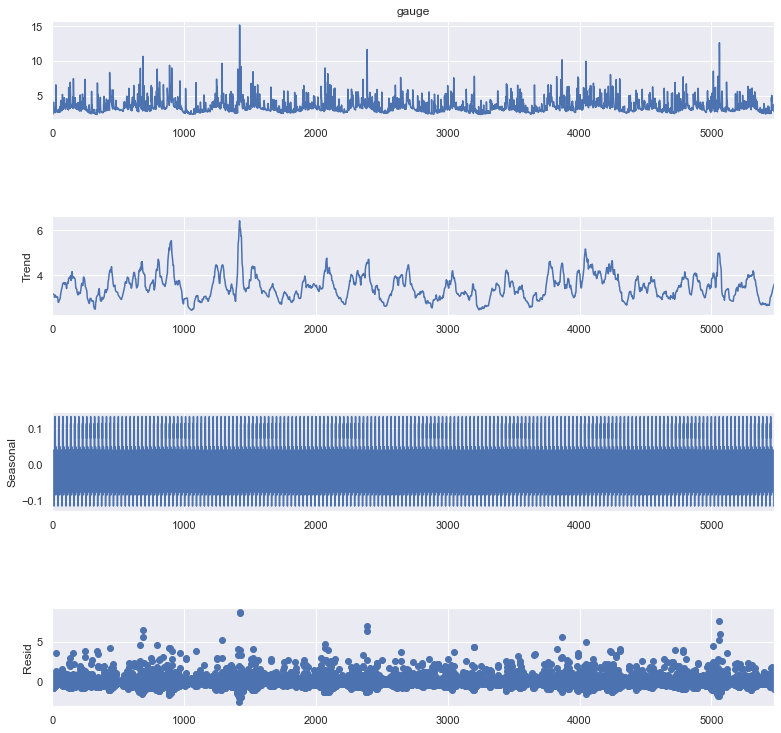

Gauge, Period: 90 Days


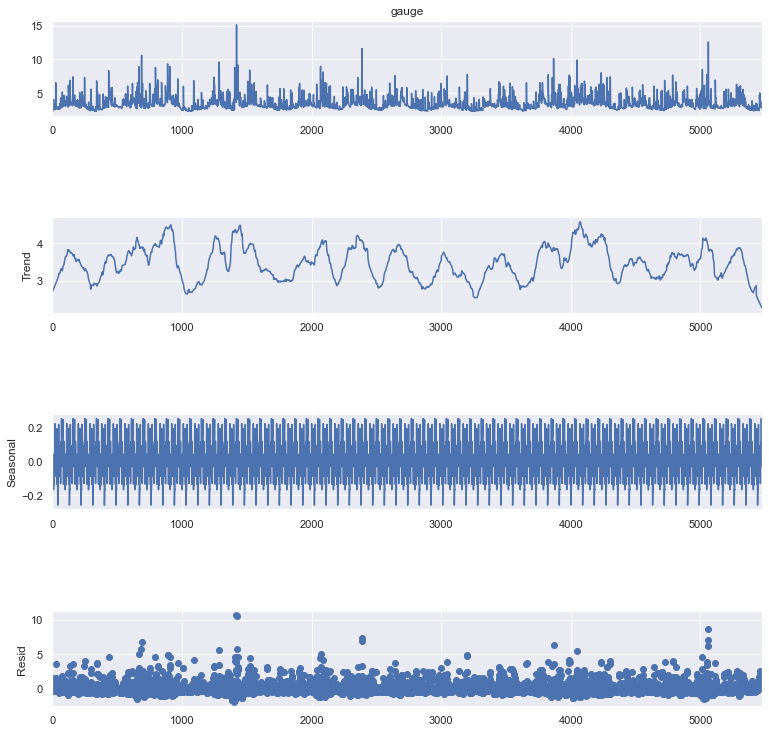

Gauge, Period: 180 Days


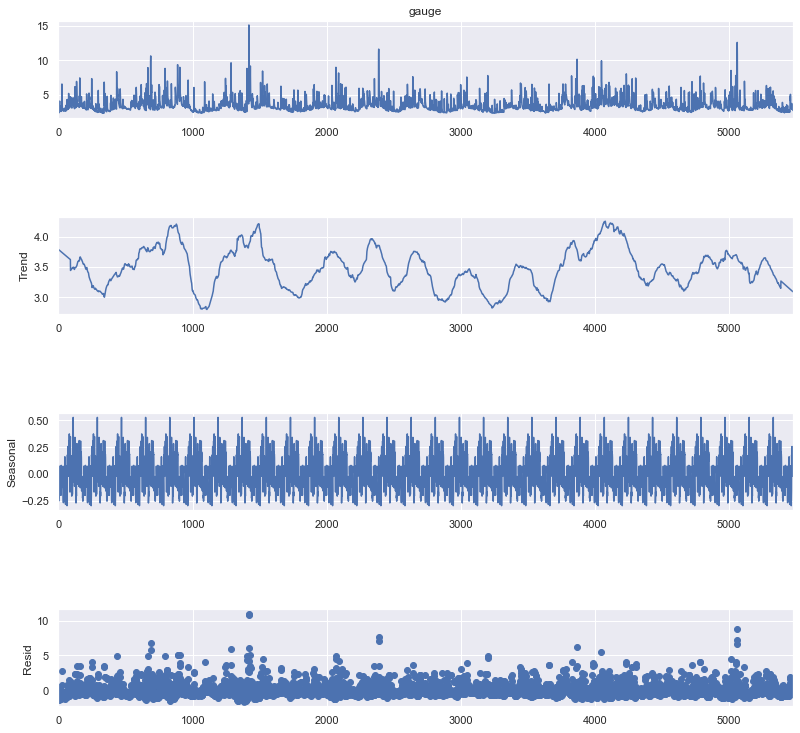

Gauge, Period: 365 Days


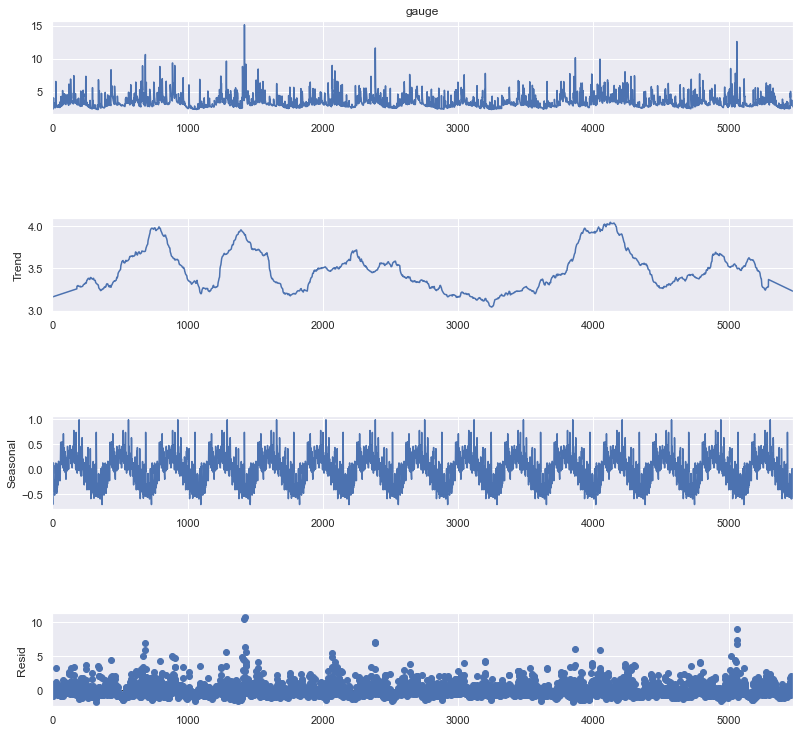

Gauge, Period: 730 Days


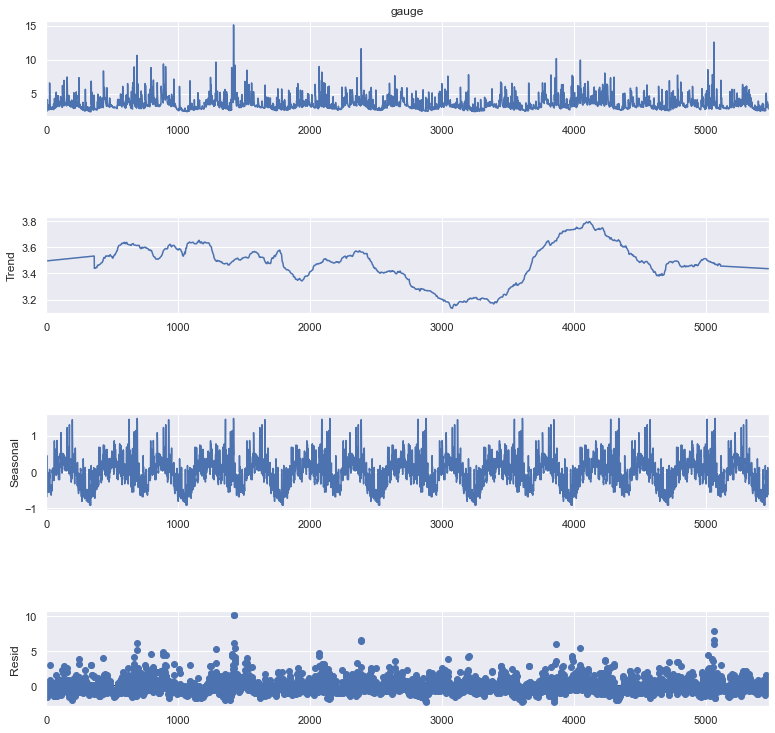

Gauge, Period: 1095 Days


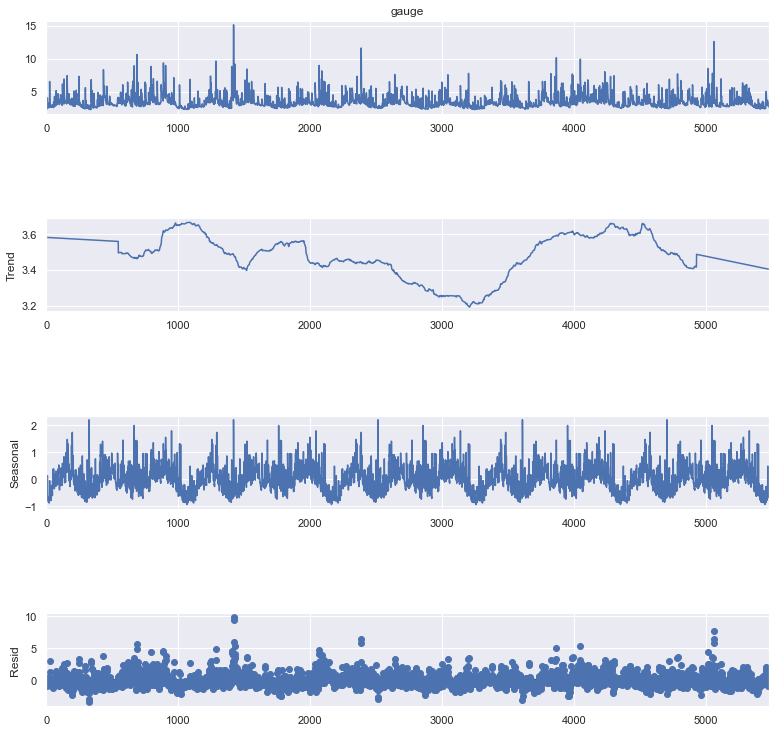

Gauge, Period: 1460 Days


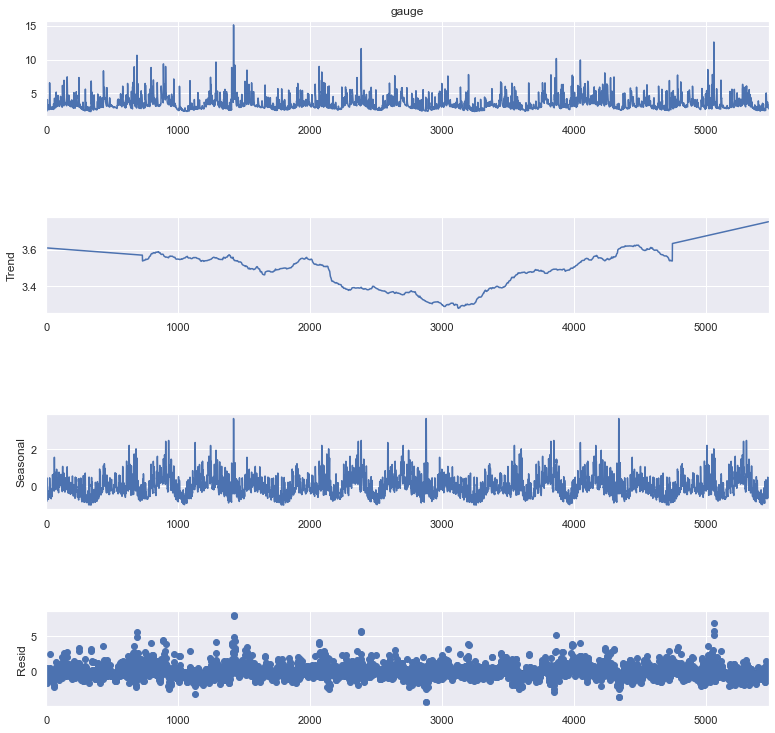

Gauge, Period: 1825 Days


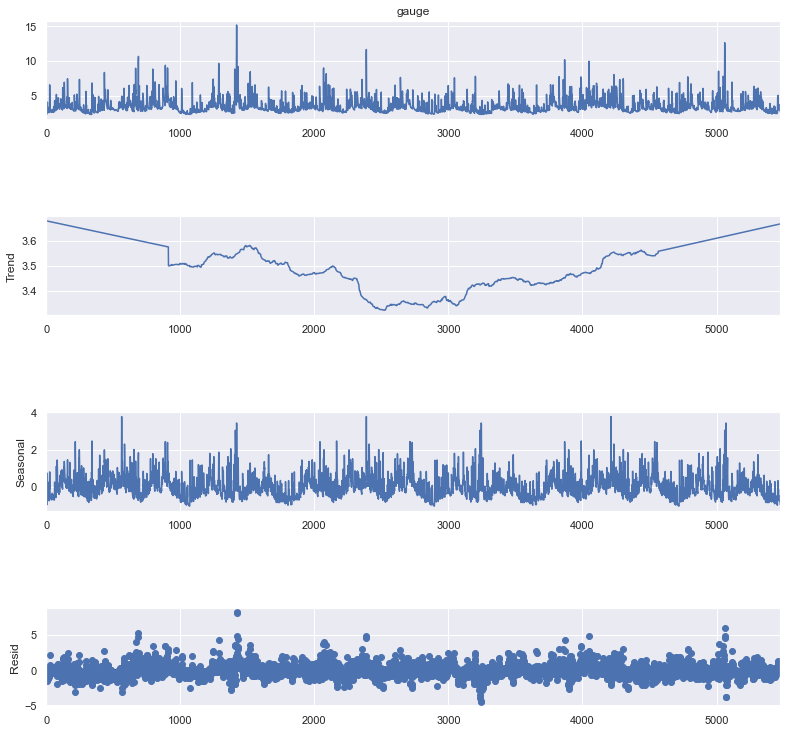

In [92]:
for period in periods:
	plot_decomp(period)

## Lag

We want to calculate each variable with a `shift()` (lag) to compare the correlation with the other variables.

You can see [documentation of shift function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) for more information.

In [93]:
days_in_month = 30

gauge[f'gauge_seasonal_shift_b_2m'] = gauge['gauge_seasonal'].shift(-2 * days_in_month)
gauge[f'{column}_seasonal_shift_b_1m'] = gauge['gauge_seasonal'].shift(-1 * days_in_month)
gauge[f'{column}_seasonal_shift_1m'] = gauge['gauge_seasonal'].shift(1 * days_in_month)
gauge[f'{column}_seasonal_shift_2m'] = gauge['gauge_seasonal'].shift(2 * days_in_month)
gauge[f'{column}_seasonal_shift_3m'] = gauge['gauge_seasonal'].shift(3 * days_in_month)

In [94]:
gauge.head()

,date,gauge,gauge_trend,gauge_seasonal,gauge_seasonal_shift_b_2m,g_seasonal_shift_b_1m,g_seasonal_shift_1m,g_seasonal_shift_2m,g_seasonal_shift_3m
0,2007-10-01,2.40,3.679807,-0.965451,-0.689281,-0.557635,NaN,NaN,NaN
1,2007-10-02,2.39,3.679692,-0.967812,-0.719148,-0.600899,NaN,NaN,NaN
2,2007-10-03,2.39,3.679577,-0.716861,-0.272357,-0.567540,NaN,NaN,NaN
3,2007-10-04,2.39,3.679462,-0.850161,0.251088,-0.510802,NaN,NaN,NaN
4,2007-10-05,2.42,3.679347,-0.776819,-0.225380,-0.577366,NaN,NaN,NaN


## Exploratory Data Analysis

Now, we'll plot the seasonality components and try to extract some knowledge.

In [127]:
gauge_3yr = gauge[gauge['date'] >= pd.Timestamp(2019,1,1)]
gauge_2020 = gauge[gauge['date'] >= pd.Timestamp(2020,1,1)]
gauge_2020 = gauge_2020[gauge_2020['date'] < pd.Timestamp(2021,1,1)]
gauge_2021 = gauge[gauge['date'] >= pd.Timestamp(2021,1,1)]
gauge_2021 = gauge_2021[gauge_2021['date'] < pd.Timestamp(2022,1,1)]

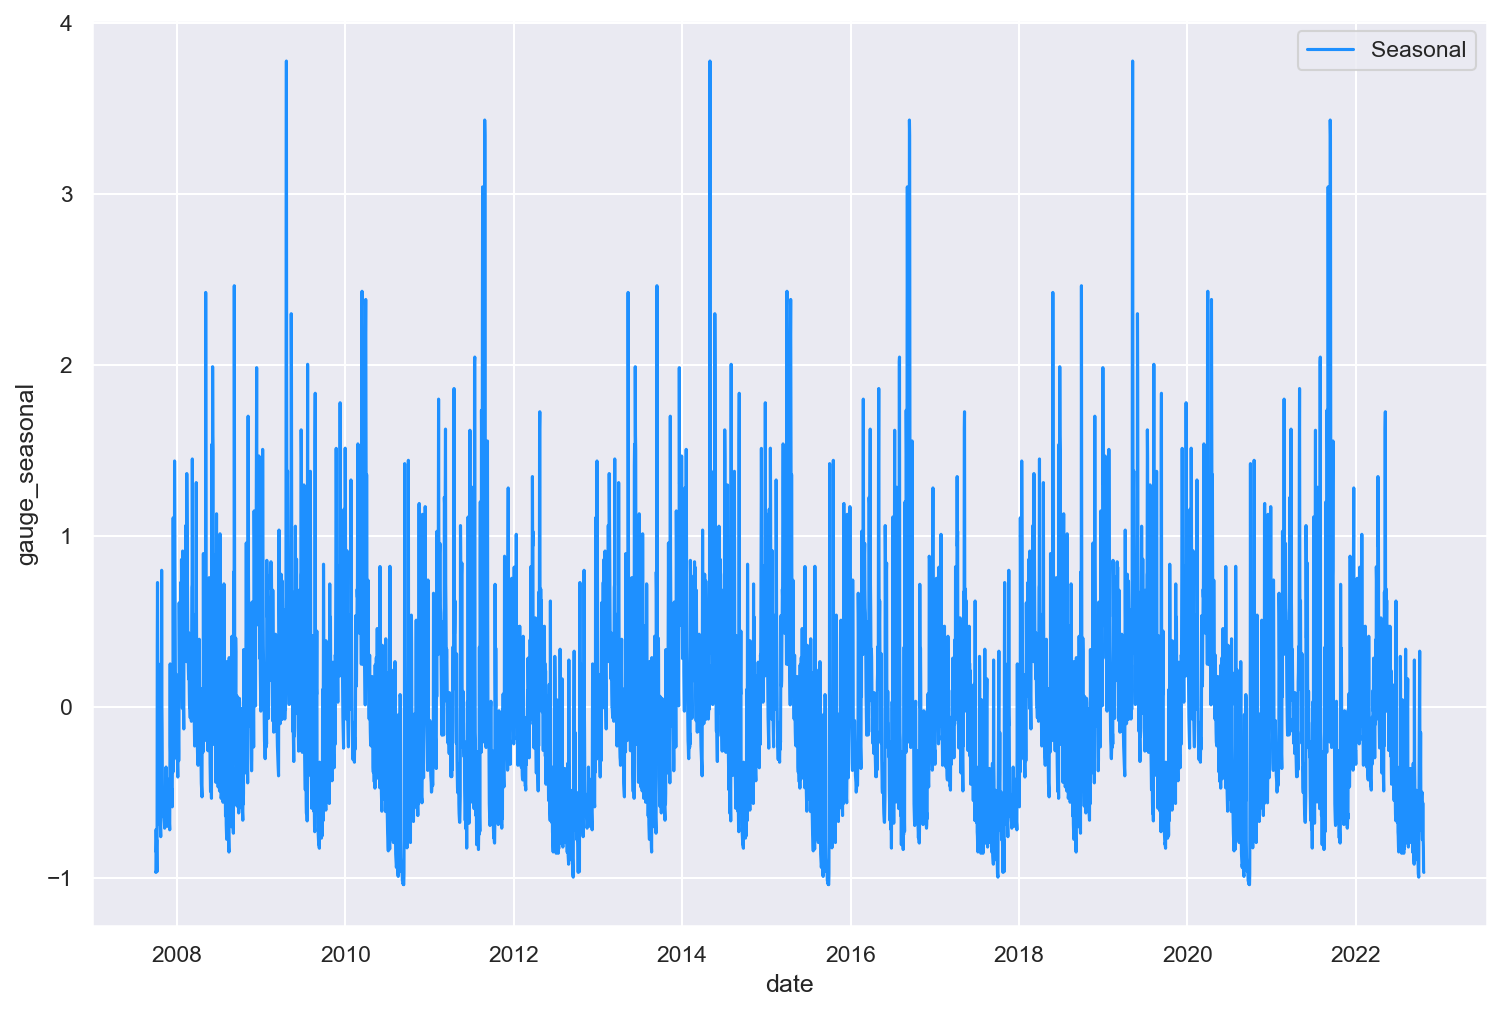

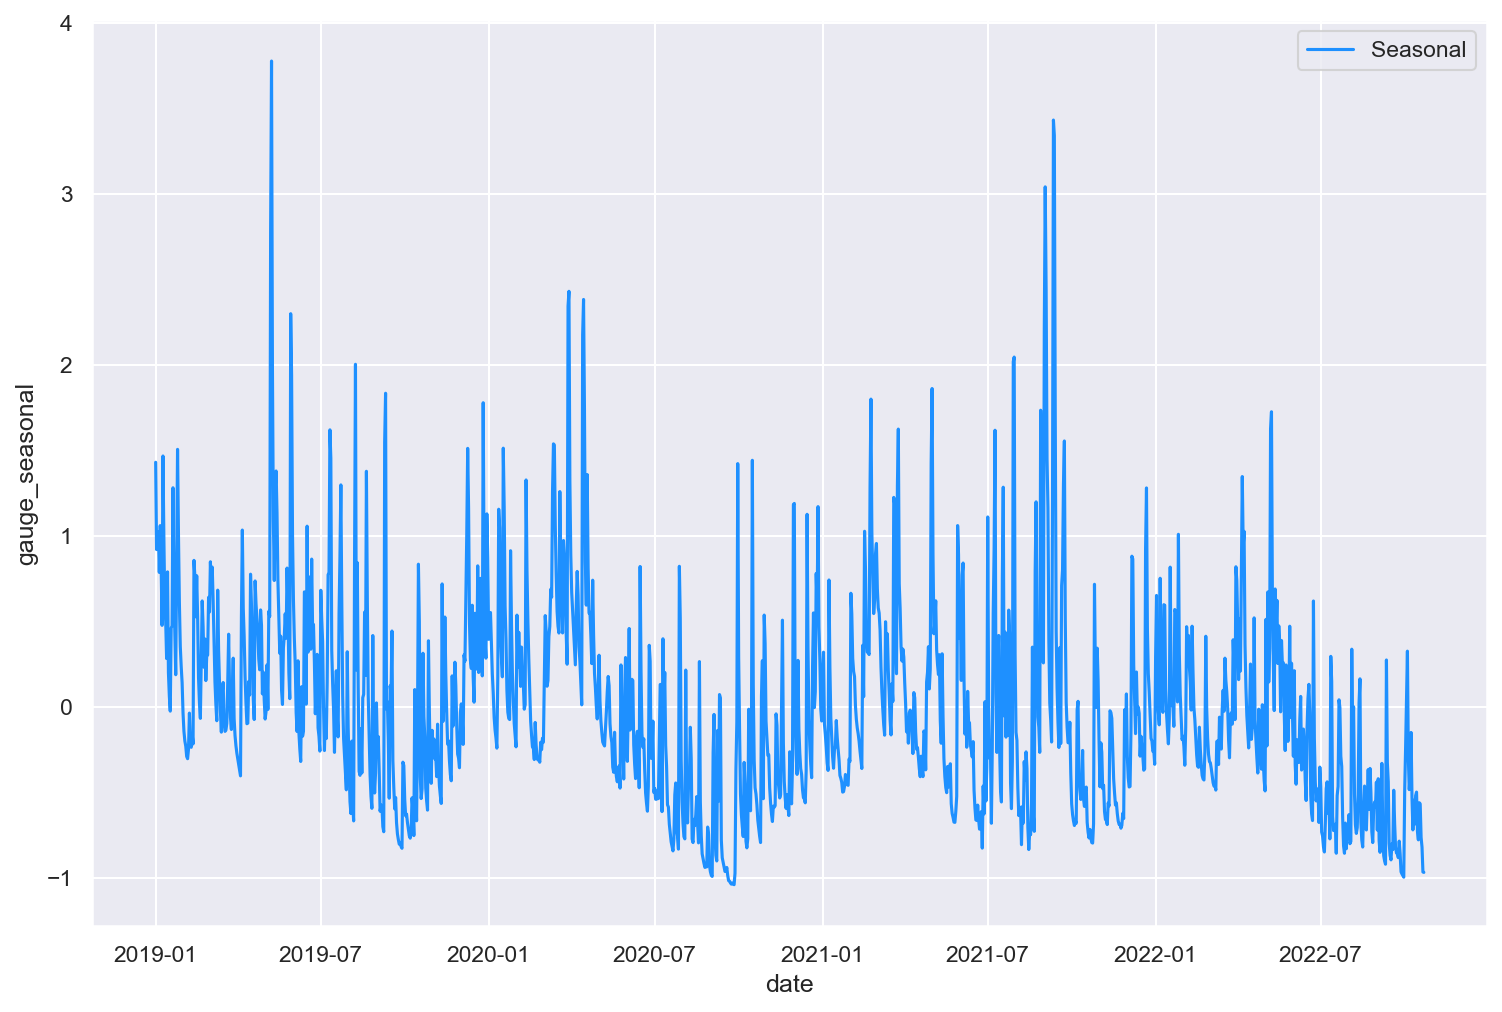

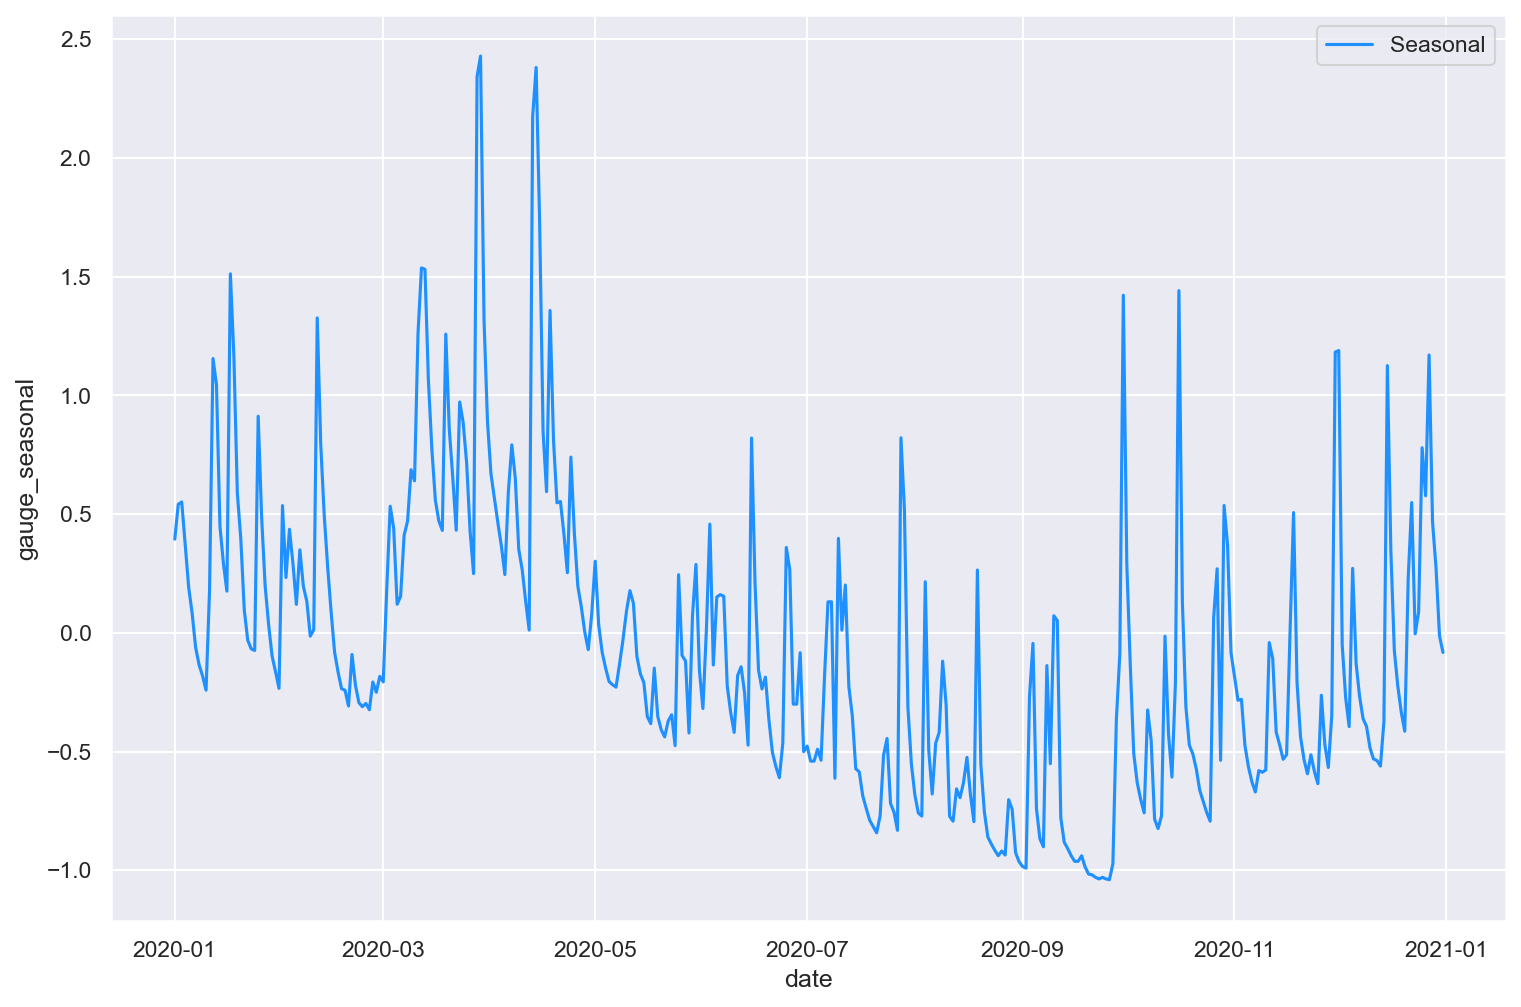

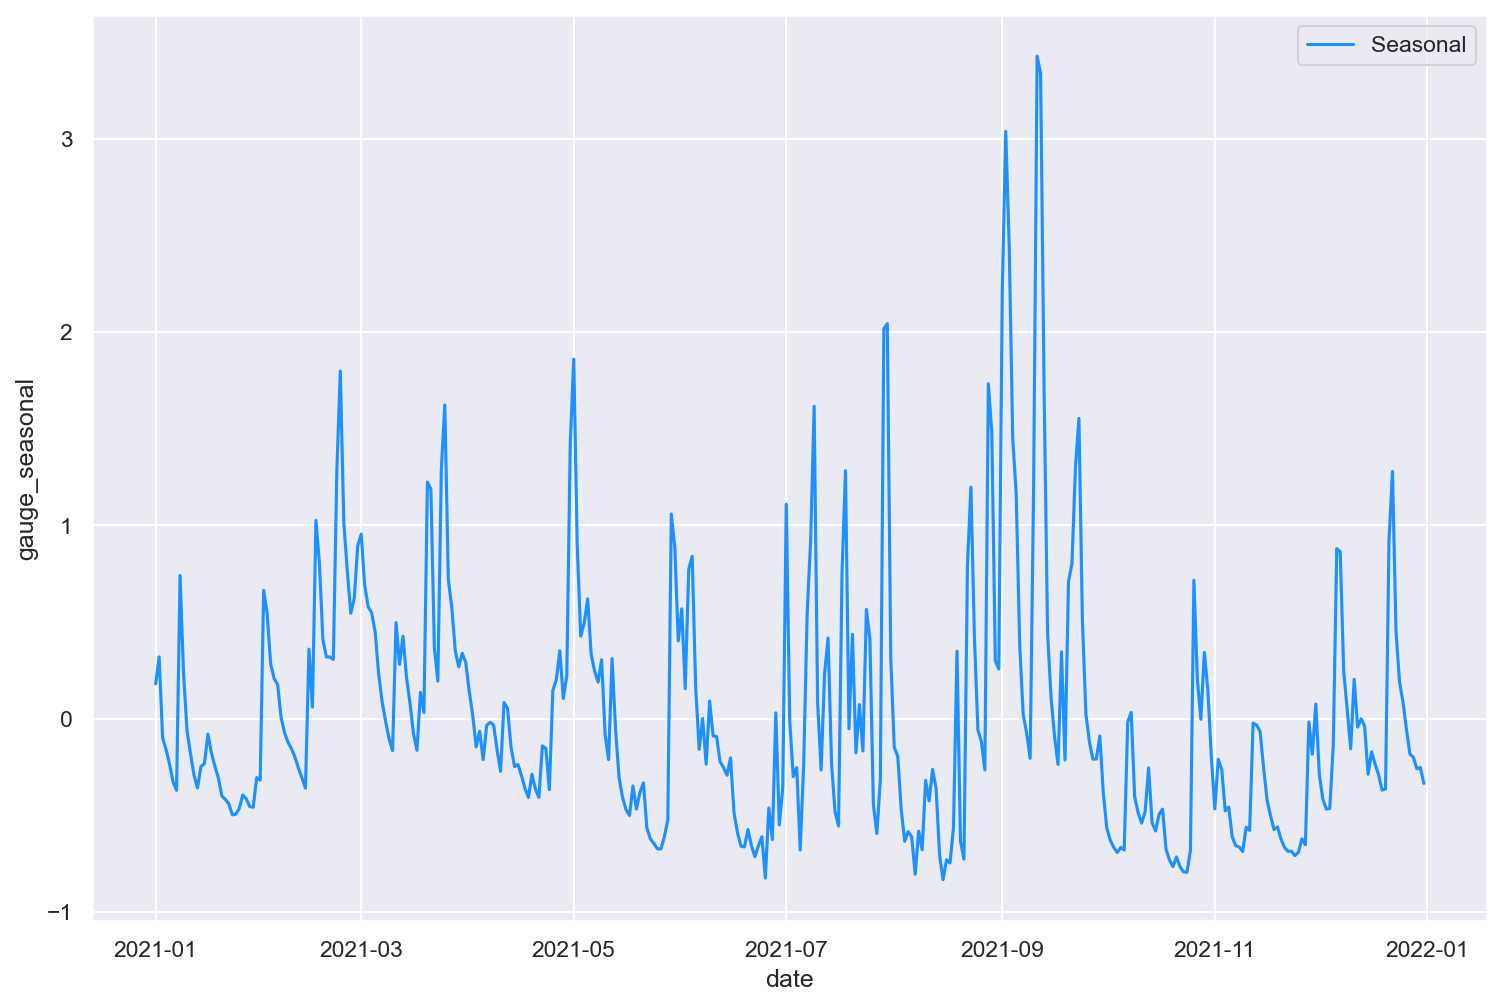

In [128]:
for df in [gauge, gauge_3yr, gauge_2020, gauge_2021]:
	plt.figure(figsize=(12,8), dpi=150)
	sns.lineplot(x=df['date'], y=df['gauge_seasonal'], color='dodgerblue', label='Seasonal')
	plt.show()

**Insights from Seasonality Plots**
Recent seasonal spikes

As we can see, the features are higher correlated in the case of shifted features (lagged ones) than the original ones.

## Autocorrelation Analysis

ACF and PACF plots: After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. Of course, with software like Statgraphics, you could just try some different combinations of terms and see what works best. But there is a more systematic way to do this. By looking at the **autocorrelation function (ACF)** and **partial autocorrelation (PACF)** plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.

* **Autocorrelation Function (ACF)**: P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter
* **Partial Autocorrelation Function (PACF)**: D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.

Autocorrelation plots help in detecting seasonality.

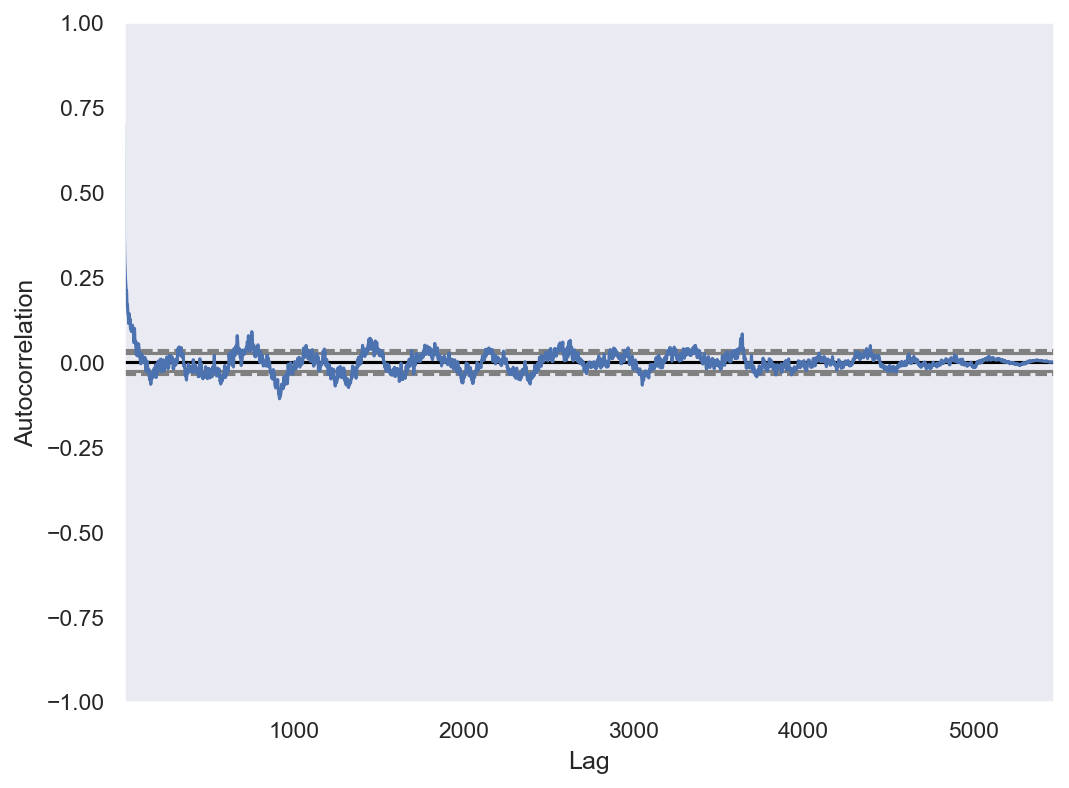

In [150]:
plt.gcf().set_size_inches(8, 6)
autocorrelation_plot(gauge['gauge'])
plt.show()

<Figure size 1200x900 with 0 Axes>

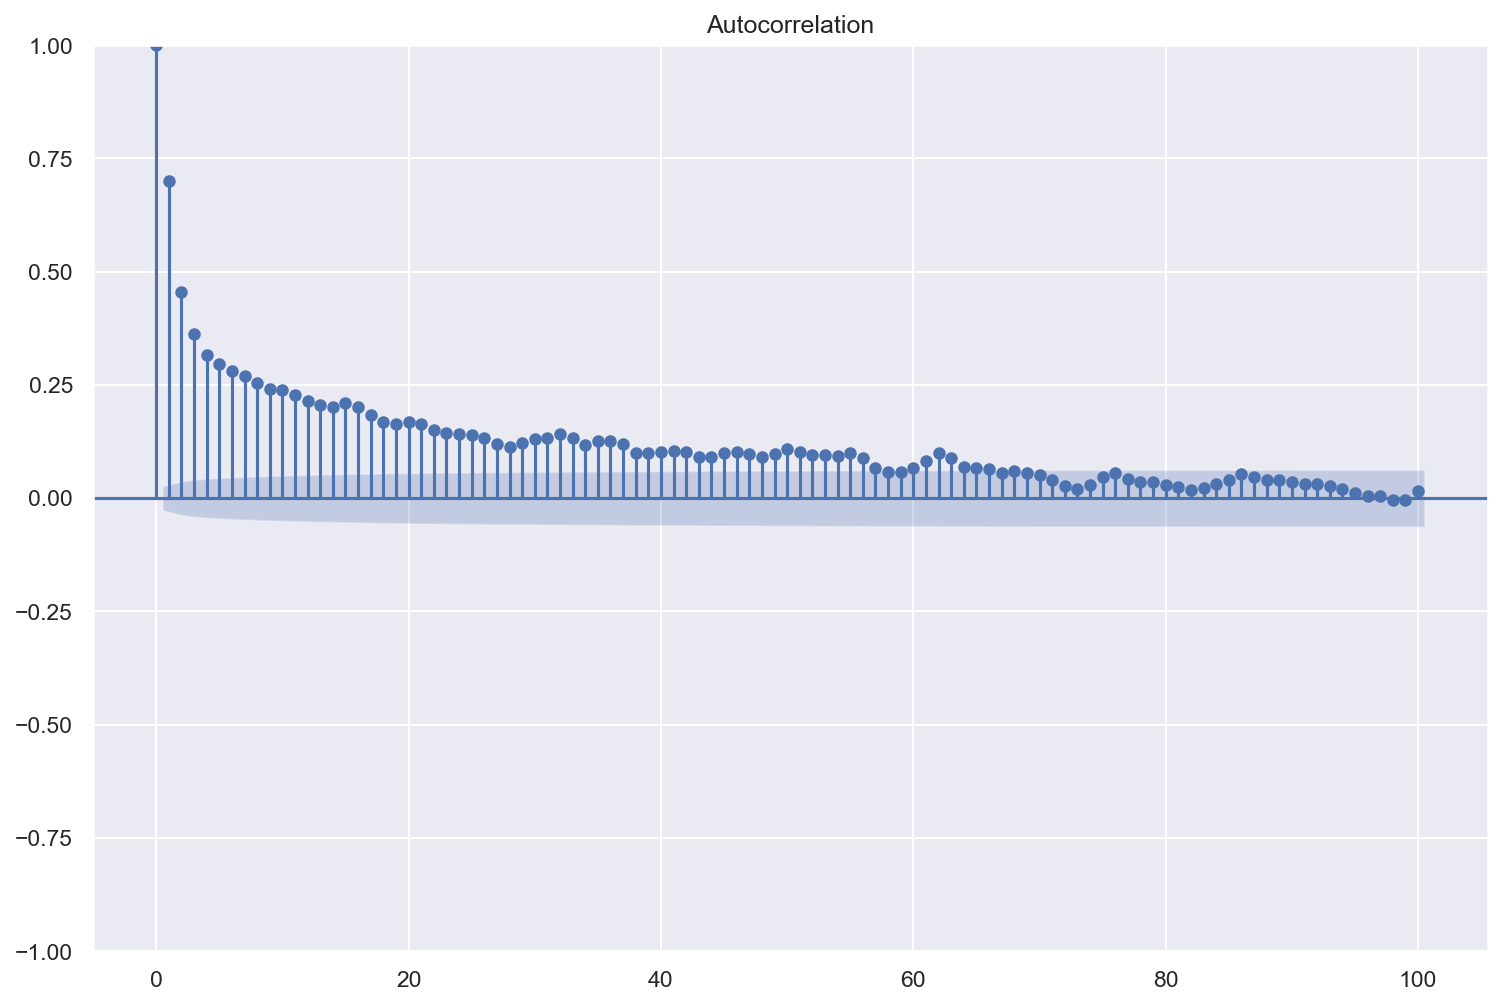

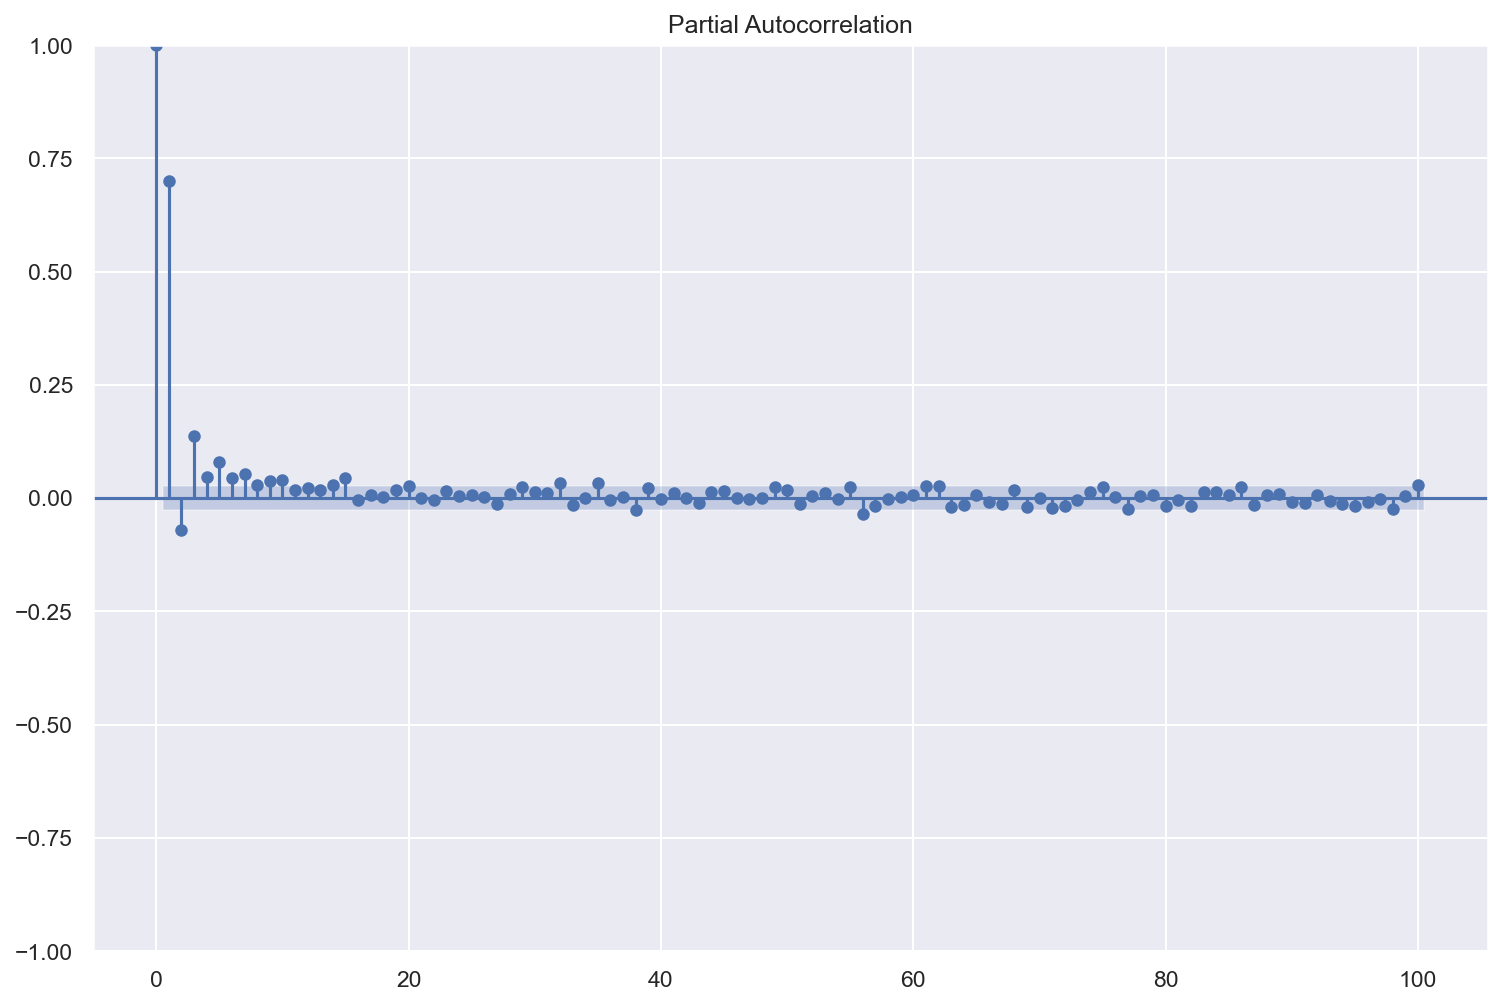

<Figure size 1200x900 with 0 Axes>

In [151]:
plot_acf(gauge['gauge'], lags=100)
plt.gcf().set_size_inches(12, 8)
plot_pacf(gauge['gauge'], lags=100)
plt.gcf().set_size_inches(12, 8)
plt.figure(figsize=(8, 6), dpi=150)

## Modeling

Time series can be either univariate or multivariate:

* **Univariate** time series only has a single time-dependent variable.
* **Multivariate** time series have a multiple time-dependent variable.

But first we'll explore cross-validation in Time Series Analysis. 

In [152]:
N_SPLITS = 3

X = gauge['date']
y = gauge['gauge']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

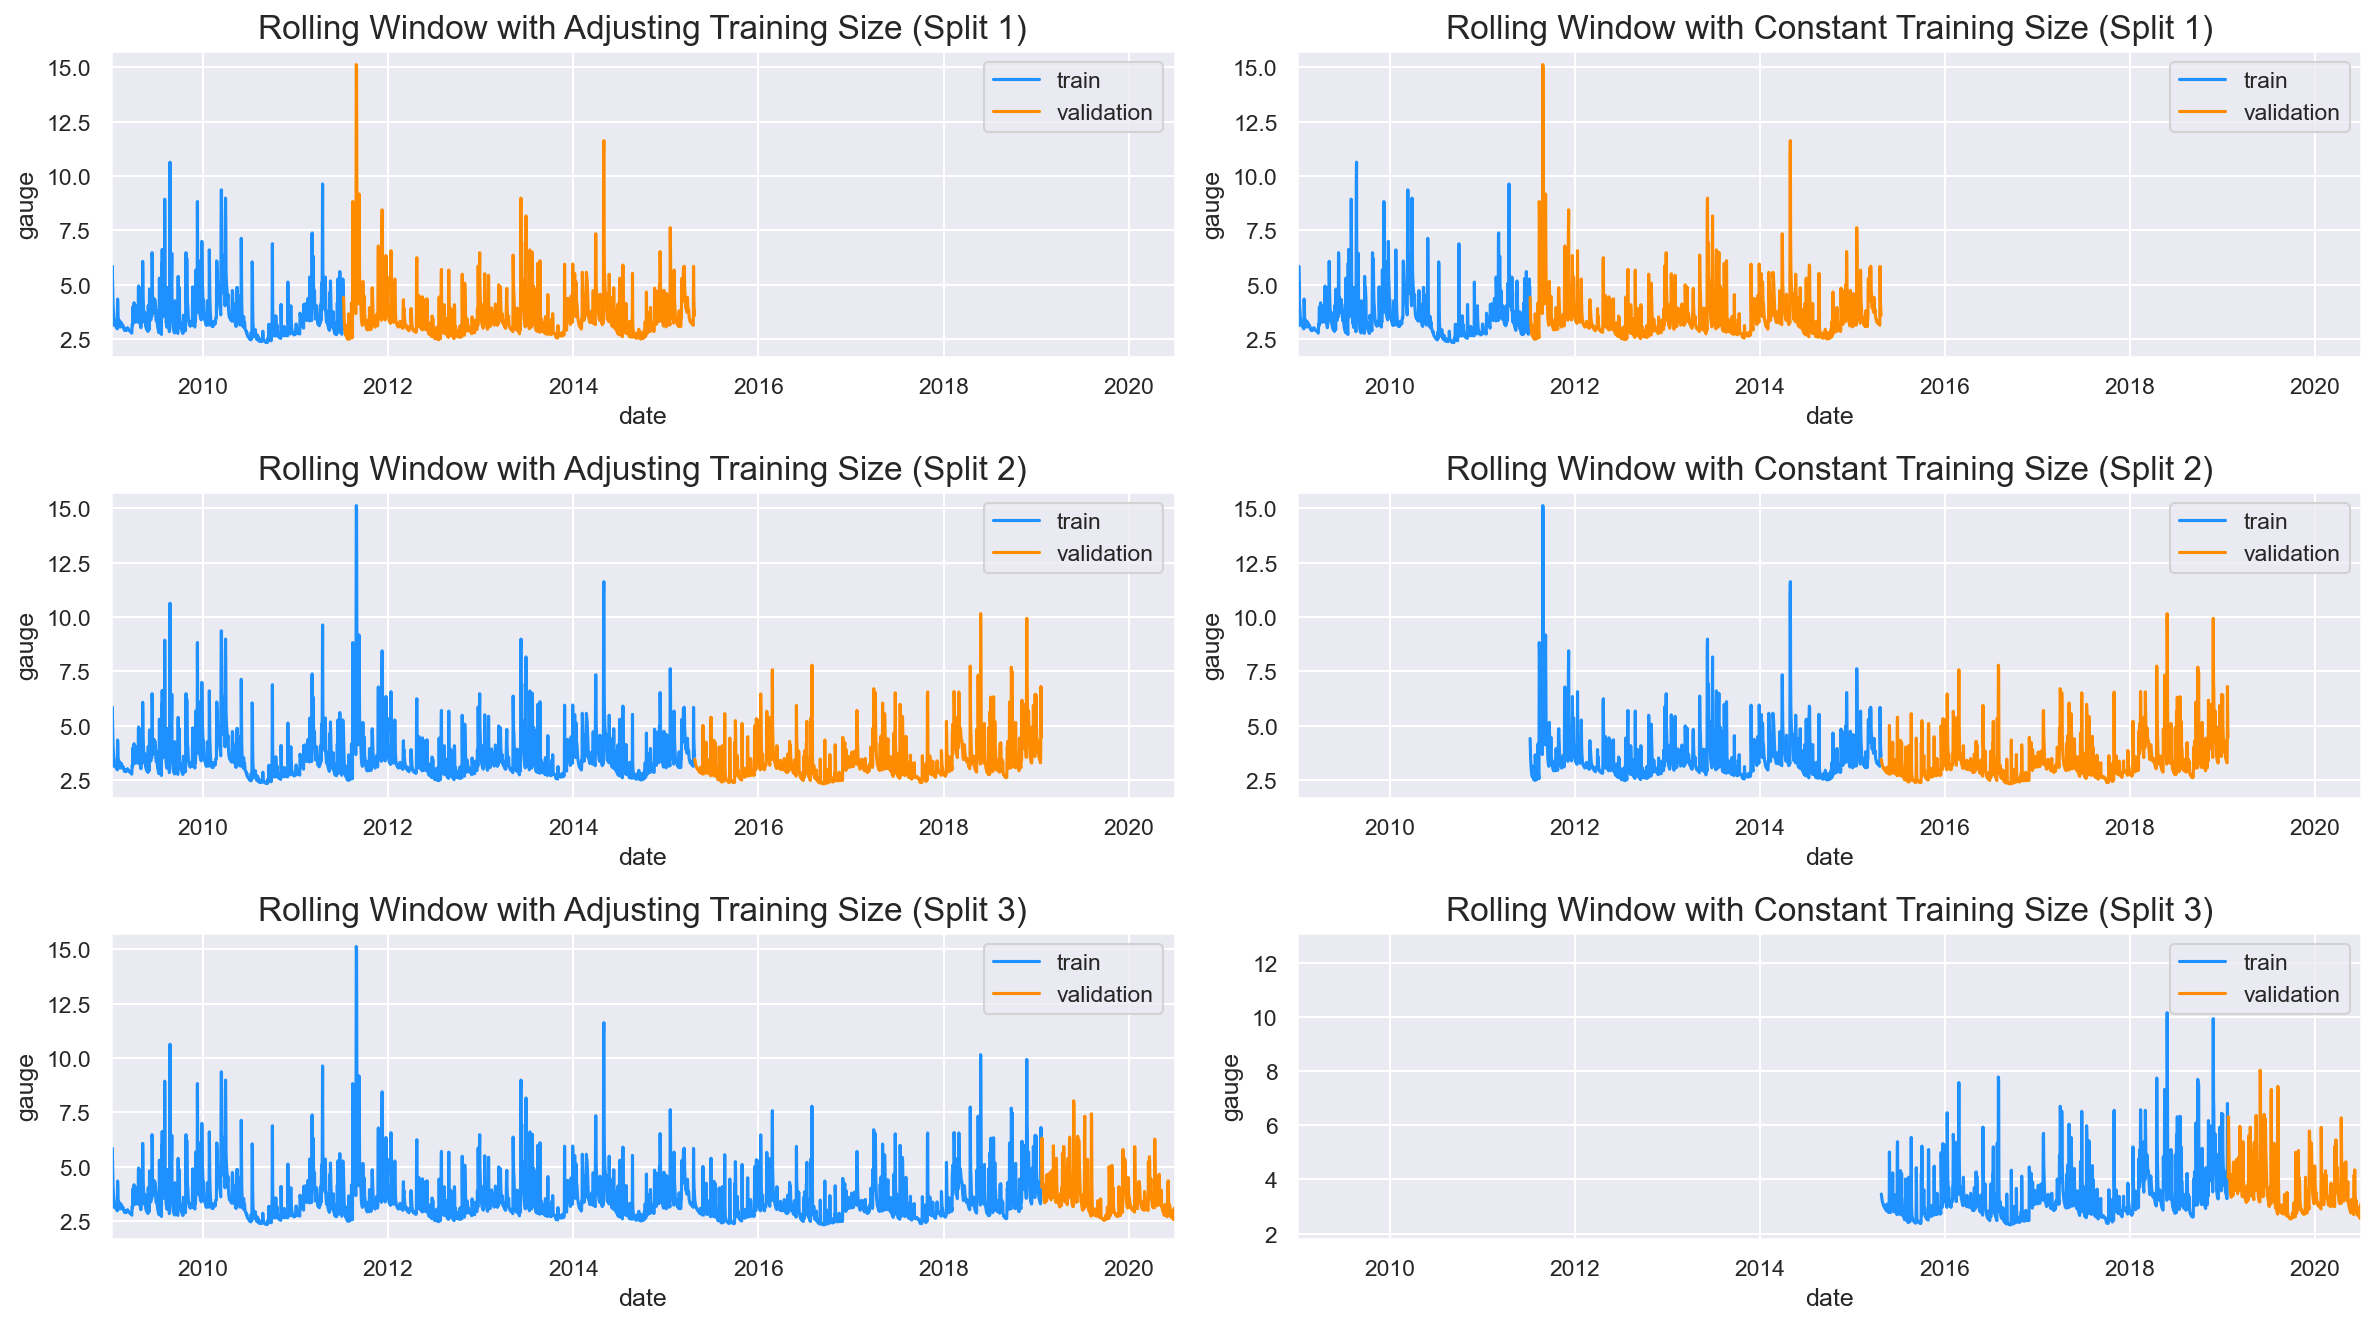

In [153]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

The idea with this plot is to understand which train and test set are we using to fit the model in each iteration. 

## Models for Univariate Time Series

**Univariate time series**: Only one variable is varying over time. For example, data collected from a sensor measuring the temperature of a room every second. Therefore, each second, you will only have a one-dimensional value, which is the temperature.

In [155]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = gauge[['date', 'gauge']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

310 5167


<a id='5.1.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">5.1.1 Prophet</p>

The first model (which also can handle multivariate problems) we are going to try is Facebook Prophet.

Prophet, or “Facebook Prophet,” is an open-source library for univariate (one variable) time series forecasting developed by Facebook.

Prophet implements what they refer to as an additive time series forecasting model, and the implementation supports trends, seasonality, and holidays.

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from fbprophet import Prophet


# Train the model
model = Prophet()
model.fit(train)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

RMSE: 1.199099789648606


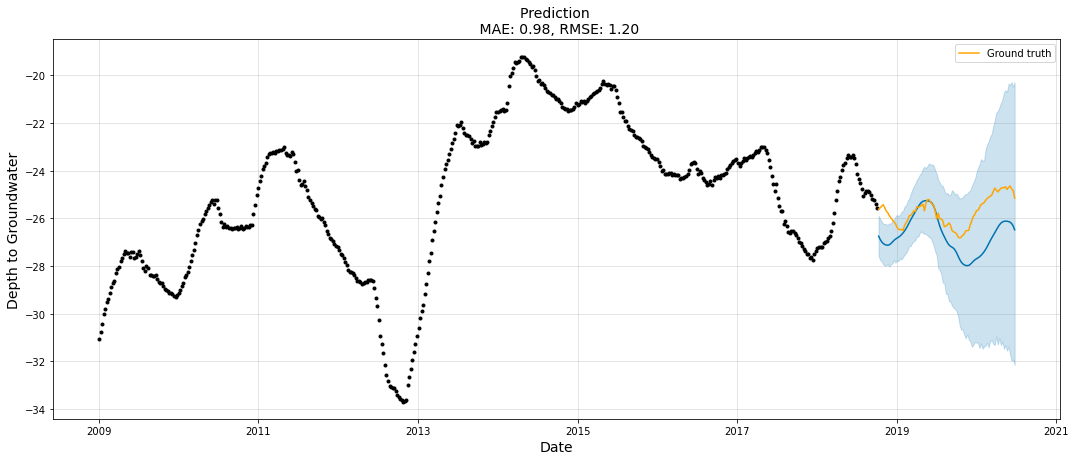

In [36]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

<a id='5.1.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">5.1.2 ARIMA</p>

The second model that i want to try is ARIMA.

The Auto-Regressive Integrated Moving Average (ARIMA) model describes the **autocorrelations** in the data. The model assumes that the time-series is **stationary**. It consists of three main parts:
* <font color='purple'>Auto-Regressive (AR) filter (long term)</font>: 
    
    $\color{purple}{y_t = c + \alpha_1 y_{t-1} + \dots \alpha_{\color{purple}p}y_{t-\color{purple}p} + \epsilon_t = c + \sum_{i=1}^p{\alpha_i}y_{t-i} + \epsilon_t}$  -> p
* <font color='orange'> Integration filter (stochastic trend)</font>
    
    -> d
* <font color='blue'>Moving Average (MA) filter (short term)</font>:

    $\color{blue}{y_t = c + \epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_{q} \epsilon_{t-q} = c + \epsilon_t + \sum_{i=1}^q{\beta_i}\epsilon_{t-i}} $  -> q 


**ARIMA**: $y_t = c + \color{purple}{\alpha_1 y_{t-1} + \dots + \alpha_{\color{purple}p}y_{t-\color{purple}p}} + \color{blue}{\epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_{q} \epsilon_{t-q}}$


ARIMA(
<font color='purple'>p</font>,
<font color='orange'>d</font>,
<font color='blue'>q</font>)

* <font color='purple'>p</font>: Lag order (reference  PACF in [Autocorrelation Analysis](#4.1-Autocorrelation-Analysis))
* <font color='orange'>d</font>: Degree of differencing. (reference  Differencing in [Stationarity](#2.3-Stationarity))
* <font color='blue'>q</font>: Order of moving average (check out ACF in [Autocorrelation Analysis](#4.1-Autocorrelation-Analysis))

### Steps to analyze ARIMA

* **Step 1 — Check stationarity**: If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast. .
* **Step 2 — Difference**: If the time series is not stationary, it needs to be stationarized through differencing. Take the first difference, then check for stationarity. Take as many differences as it takes. Make sure you check seasonal differencing as well.
* **Step 3 — Filter out a validation sample**: This will be used to validate how accurate our model is. Use train test validation split to achieve this
* **Step 4 — Select AR and MA terms**: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.
* **Step 5 — Build the model**: Build the model and set the number of periods to forecast to N (depends on your needs).
* **Step 6 — Validate model**: Compare the predicted values to the actuals in the validation sample.

In [37]:
from statsmodels.tsa.arima_model import ARIMA

# Fit model
model = ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred, se, conf = model_fit.forecast(90)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

RMSE: 0.8858252746421527


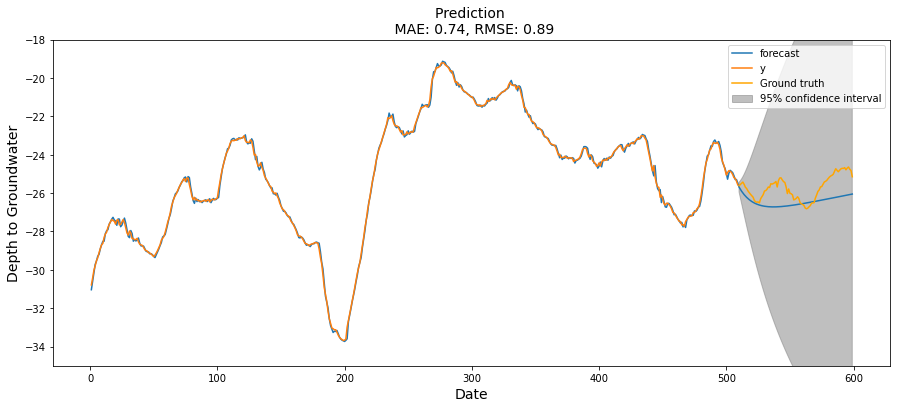

In [38]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model_fit.plot_predict(1, 599, ax=ax)
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

ax.set_ylim(-35, -18)
plt.show()

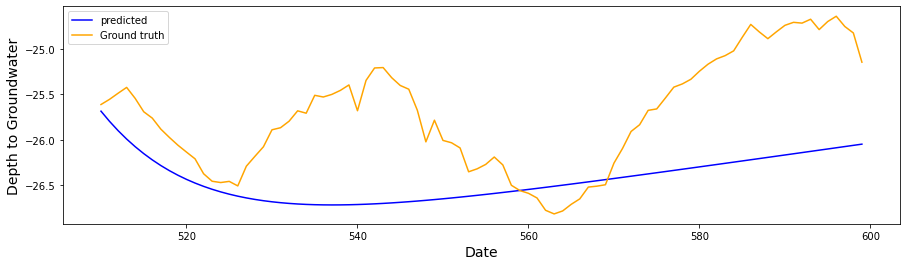

In [39]:
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='predicted') #navajowhite
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

<a id='5.1.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">5.1.3 Auto-ARIMA</p>

In [40]:
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 866 kB/s 
     |████████████████████████████████| 2.1 MB 4.4 MB/s 
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [41]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-631.136, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-242.692, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-574.047, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-427.347, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-243.054, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-629.209, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-629.237, Time=0.77 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-492.779, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-611.065, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-628.351, Time=1.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-632.995, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-428.258, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-575.735, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-631.069, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]          

As we saw in the previous Steps, AutoARIMA (auto_arima) validates that (1,1,1) is the best configuration for (p,d,q).

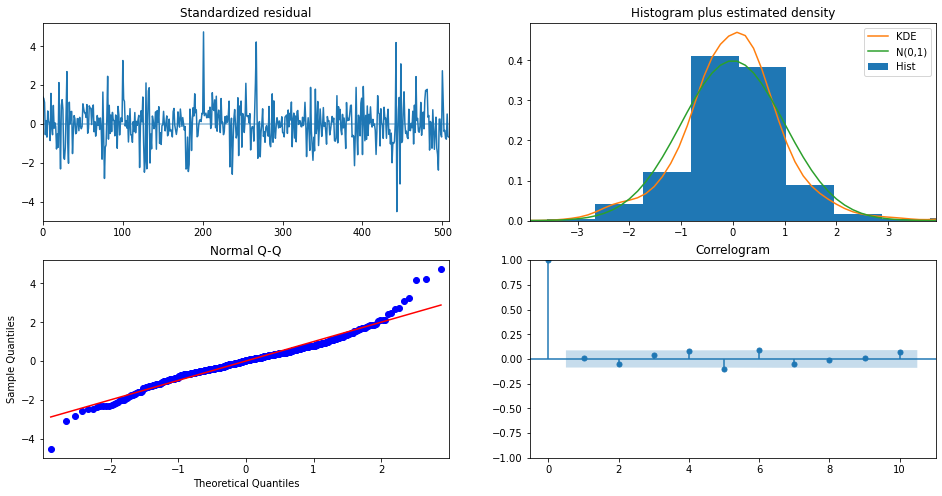

In [42]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

So how to interpret the plot diagnostics?

* **Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance between (-4, 4).

* **Top Right**: The density plot suggest normal distribution with mean zero.

* **Bottom left**: The most part of the blue dots are over the red line, so it seems that the distribution in very low skewed (not skewed for me).

* **Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.

<a id='5.1.4'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">5.1.4 LSTM</p>

We are going to use a multi-layered LSTM recurrent neural network to predict the last value of a sequence of values.

The following data pre-processing and feature engineering need to be done before construct the LSTM model.
* Create the dataset, ensure all data is float.
* Normalize the features.
* Split into training and test sets.
* Convert an array of values into a dataset matrix.
* Reshape into X=t and Y=t+1.
* Reshape input to be 3D (num_samples, num_timesteps, num_features).

In [43]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
#Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.81796644],
       [-0.79970385],
       [-0.7745311 ],
       [-0.74679171],
       [-0.73099704],
       [-0.71253702],
       [-0.7023692 ],
       [-0.68410661],
       [-0.66890424],
       [-0.65528134]])

In [44]:
# Defines the rolling window
look_back = 52
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

406 90


In [45]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

Epoch 1/5
406/406 [==============================] - 4s 5ms/step - loss: 0.0178 - val_loss: 0.0091
Epoch 2/5
406/406 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 3.7996e-04
Epoch 3/5
406/406 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 8.1765e-04
Epoch 4/5
406/406 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 3.7027e-04
Epoch 5/5
406/406 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0031
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            92672     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 25)                1625      
___________

In [46]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

RMSE: 0.8032011475525961


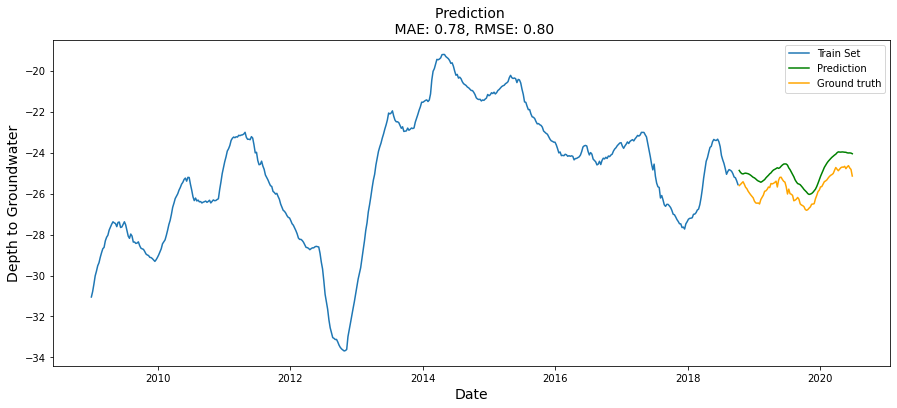

In [47]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

In [48]:
feature_columns = [
    'rainfall',
    'temperature',
    'drainage_volume',
    'river_hydrometry',
]
target_column = ['depth_to_groundwater']

train_size = int(0.85 * len(df))

multivariate_df = df[['date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,rainfall,temperature,drainage_volume,river_hydrometry
0,2009-01-01,-31.048571,0.000000,1.657143,-28164.918857,2.371429
1,2009-01-08,-30.784286,0.285714,4.571429,-29755.789714,2.314286
2,2009-01-15,-30.420000,0.028571,7.528571,-25463.190857,2.300000
3,2009-01-22,-30.018571,0.585714,6.214286,-23854.422857,2.500000
4,2009-01-29,-29.790000,1.414286,5.771429,-25210.532571,2.500000


In [49]:
from fbprophet import Prophet


# Train the model
model = Prophet()
model.add_regressor('rainfall')
model.add_regressor('temperature')
model.add_regressor('drainage_volume')
model.add_regressor('river_hydrometry')

# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

RMSE: 0.9940444133552163


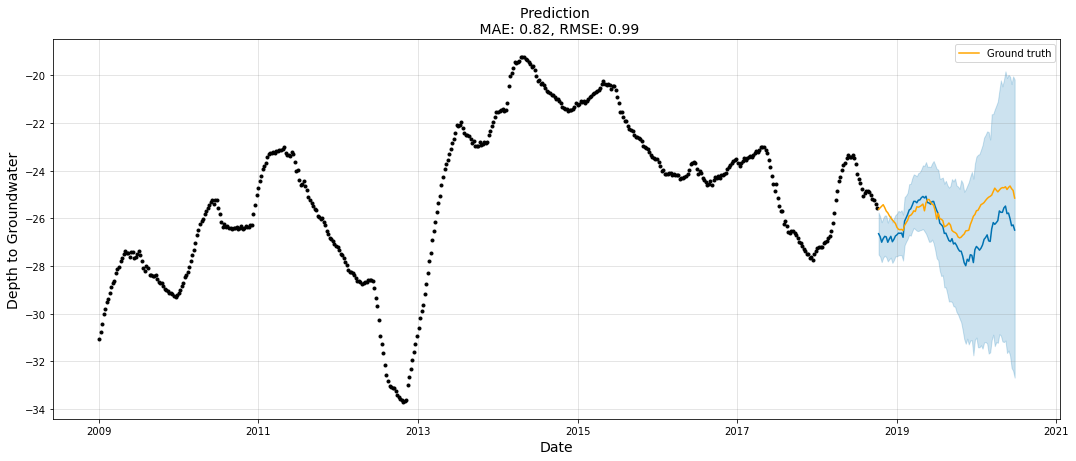

In [50]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

<a id='6'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">6. Conclusions 💎</p>

The best results are taken from Univariate LSTM (with rolling window of 1 year) and multi-variate Prophet.

<a id='7'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">7. References 📝</p>

Here I am going to reference some useful links that I have used to build this notebook
* Special reference for the helpful information and plots - https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting
* ARIMA - https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06
* Auto-ARIMA - https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
* Keras LSTM - https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* Prophet - https://towardsdatascience.com/time-series-prediction-using-prophet-in-python-35d65f626236
* Special reference - https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting/notebook#Models
* Cyclical features - https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
* ADF - https://medium.com/@cmukesh8688/why-is-augmented-dickey-fuller-test-adf-test-so-important-in-time-series-analysis-6fc97c6be2f0
* ACF/PACF - https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8
* LSTM - https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba